<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* similaridad: KNN
* SVM, Decision trees y Redes neuronales
* Tipos de fronteras de clasificación y regresión.
* Métodos de *kernel*.
* Selección de hı́per-parámetros estructurales en SVM, Arboles de Decisión, k-NN y Redes Neuronales.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de discusión y entrega: 30 de Noviembre y 3 de Diciembre (13:00 hrs) respectivamente.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF393-II-2018]

<hr style="height:2px;border:none"/>

### Paquetes de instalación

Como es usual utilizaremos *numpy, scipy, matplotlib* y *sklearn*. Además de éstas se necesitará instalar **keras**, una librerı́a en python para prototipado rápido de modelos basados en redes neuronales, muy similar en espı́ritu a *sklearn*. La librerı́a puede usar *TensorFlow* o *Theano* como backend, siendo éstas las librerı́as más populares para desarrollar nuevos modelos de redes neuronales o implementar eficientemente modelos conocidos con fines prácticos. Para detalles sobre la instalación puede revisar [[1]](#refs) o escribir un email a su ayudante.



La tarea se divide en secciones:

[1.](#primero) Tipos de fronteras en clasificación  
[2.](#segundo) Un problema* Multi-label*  
[3.](#tercero) *Taxi Trip Duration*: Predicción de duración de viaje  
[4.](#cuarto) Entendimiento de imágenes de personas

<a id="tercero"></a>

## 3. *Taxi Trip Duration*: Predicción de duración de viaje

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/Newyorkcity_taxi_motion_banner.jpg" />


En esta actividad trabajaremos con un dataset de una competencia en la plataforma Kaggle, el cual se llama **New York City Taxi Trip Duration** y que puede ser accedido a través del siguiente __[link](https://www.kaggle.com/c/nyc-taxi-trip-duration/)__. Como se puede ver es una competencia para predecir la duración del viaje de un taxi en Nueva York, por lo que es un problema de regresión que resulta altamente no lineal  y no determinista debido a las invariantes que tiene, por ejemplo un viaje de un punto a otro puede durar distinto tiempo dependiendo de múltiples factores, como el horario, la congestión de ese día u otros.

La métrica de evaluación de la competencia y la que utlizaremos será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

O en código Python:
```python
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))
```


Descarge los datos de la competencia, únicamente trabajaremos con el archivo *train.zip* o *train.csv*, ya que no conocemos los valores reales del conjunto *test*, tendrémos que simularlo.

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.
```python
import pandas as pd
df = pd.read_csv("train.csv")
df.info()
df.head()
output = df['trip_duration'].values
```

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.
```python
eliminar outliers
df = df[(df['trip_duration']<=100000)]
```

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hcaer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  
```python
from geopy.distance import great_circle
import numpy as np
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()
```
<div class="alert alert-info"> *Si el proceso demora mucho, lo que se aconseja es realizarlo una vez, guardar los datos en disco y luego leerlos cada vez que se experimenta con los códigos para las pruebas de los modelos de aprendizaje* </div>

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.
```python    
y = df['trip_duration'].values
df.drop("trip_duration",axis=1,inplace=True)
X = df.values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
from sklearn.preprocessing import RobustScaler,StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler = RobustScaler(with_centering=True, with_scaling=True)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
```

> e) En base a la definición del problema de ésta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.
```python
model = choose #SVM, Decision Trees or Neural Network
model.fit(X_train_scaled,y_train)
print "ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled),y_train)
print "ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled),y_test)
```

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?
```python
def graficar_predicciones(real,predecido):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    plt.show()
graficar_predicciones(y_test,model.predict(X_test_scaled))
```

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).


> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.
```python
"""define your transformation!!"""
def transformar(valor):
    return valor #identidad
def destransformar(valor):
    return valor #identidad
model.fit(X_train_scaled,transformar(y_train))
print "ERROR RMSLE de training: ", rmsle(destransformar(model.predict(X_train_scaled)),y_train)
print "ERROR RMSLE de test: ", rmsle(destransformar(model.predict(X_test_scaled)),y_test)
```

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.
```python
"""Separar viajes largos de viajes cortos"""
u = np.mean(X_train["distancia_viaje_km"])
mask = X_train["distancia_viaje_km"] <= u
X_train_1 = X_train[mask] #viaje cortos
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask] #viaje largos
y_train_2 = y_train[~mask]
```

Primero se define la función de RMSLE (Root Mean Squared Logarithm Error):

In [1]:
import numpy as np
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

Luego se cargan los datos:

In [5]:
import pandas as pd
df = pd.read_csv("train.csv")
print(df.info())
print(df.head())
output = df['trip_duration'].values
output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06

array([ 455,  663, 2124, ...,  764,  373,  198], dtype=int64)

Dentro del dataset se encuentran 10 variables y 2 datos que son de identificación. <br>
Id: string que correspende a la id que se le da al viaje, es para identificar y no sirve como variable.<br>
vendor_id: entero que corresponde al código asociado al vendedor. Considerado variable ya que cada conductor conduce de distinta forma favoreciendo o perjudicando el tiempo de viaje.<br>
pickup_datetime, dropoff_datetime: strings que permiten conocer el tiempo en que se tomó y dejó a los pasajeros. El tiempo puede influir debido al tráfico.<br>
passenger_count: entero con la cantidad de pasajeros. Este podría influir debido a que un pasajero se baje antes.<br>
pickup_longitude, pickup_latitude, dropoff_latitude, dropoff_latitude: variables tipo float que proporciona información de la ubicación en que se toma y deja al pasajero. El sector donde ocurre esto influye en los tiempos.<br>
store_and_fwd_flag: tipo char que determina si los datos fueron guardados en el almacenamiento del vehículo o si fueron enviados inmediatamente. Este dato no debe influir en el tiempo.<br>
trip_duration: variable entera que indica el tiempo en que demora en realizar el viaje. Esta sería la variable dependiente.

Ahora, para un mejor análisis se genera un boxplot de la variable trip_duration:

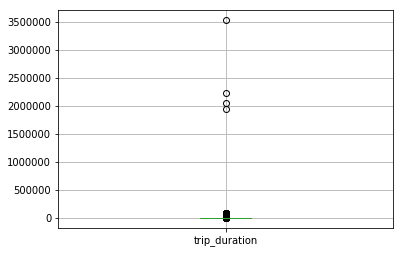

In [23]:
df.boxplot(column=['trip_duration'])

El boxplot resultante indica que hay varios outliers que ni siquiera permiten ver bien el boxplot. Por lo que usando un histograma y acotando el rango se obtiene el siguiente histograma.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029C81F53BA8>]],
      dtype=object)

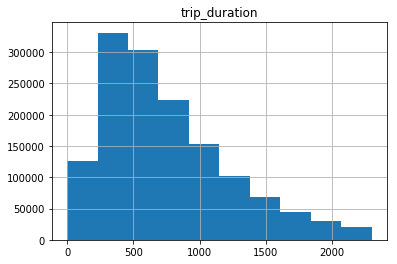

In [26]:
df.hist(column=['trip_duration'], range = (0,2300))

Con el histrograma se puede notar que la mayor cantidad de viajes toma un tiempo entre 250 segundos y 750.

b) Para un mejor análisis, se eliminan los outliers. Como estos datos son muy distintos a los de la muestra, pueden afectar al entrenamiento de muy mala manera.

In [39]:
df = df[(df['trip_duration']<=100000)]

Se genera nuevamente el boxplot:

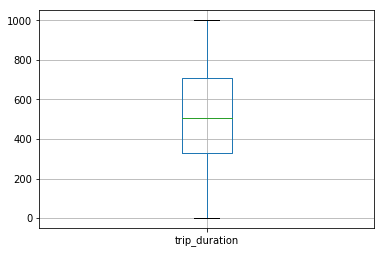

In [40]:
df.boxplot(column=['trip_duration'])

Ahora, se puede notar que la mediana se encuentra de los 500 segundos y como la caja se ve uniforme, podemos decir que la cantidad de datos se distribuye normalmente al rededor de la mediana.

c)

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html  
[3] https://en.wikipedia.org/wiki/Kernel_method  
[4] http://scikit-learn.org/stable/modules/multiclass.html  
[5] Tsoumakas, G., & Katakis, I. (2007). *Multi-label classification: An overview*. International Journal of Data Warehousing and Mining (IJDWM), 3(3), 1-13.  
[6] https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-6-feature-engineering-and-feature-selection-8b94f870706a  
[7] Bishop, C. M. (2006). *Pattern recognition and machine learning (information science and statistics)* springer-verlag new york. Inc. Secaucus, NJ, USA.